In [1]:
import torch
from torch import nn
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get data

In [3]:
import requests
import zipfile
from pathlib import Path
import os

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
        
    # Unzip data
    with zipfile.ZipFile(os.path.join(data_path,'pizza_steak_sushi.zip'),"r") as fp:
        fp.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...


# Data Preparation

In [4]:

def walk_through_dir(dir_path):
    """
      Walks through dir_path returning its contents.
      Args:
        dir_path (str or pathlib.Path): target directory

      Returns:
        A print out of:
          number of subdiretories in dir_path
          number of images (files) in each subdirectory
          name of each subdirectory
      """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
np.array(img).shape




steak
Random image path: data/pizza_steak_sushi/train/steak/2878151.jpg
Image class: steak
Image height: 512
Image width: 512


(512, 512, 3)

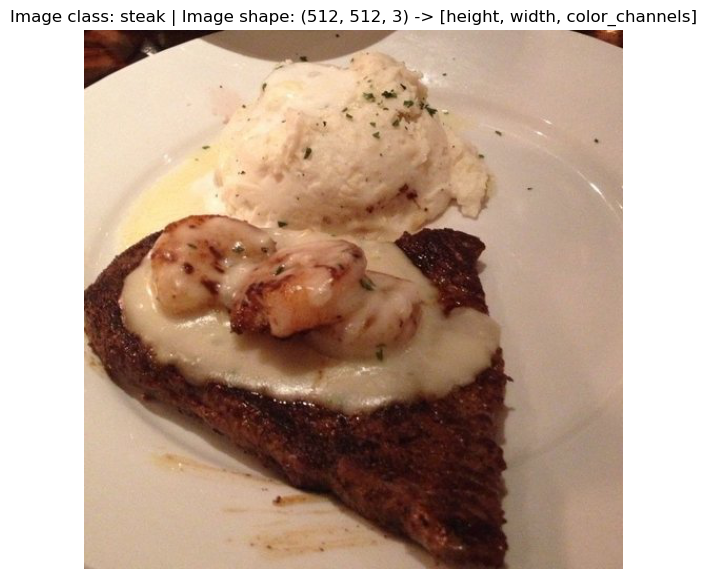

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# Transforming data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

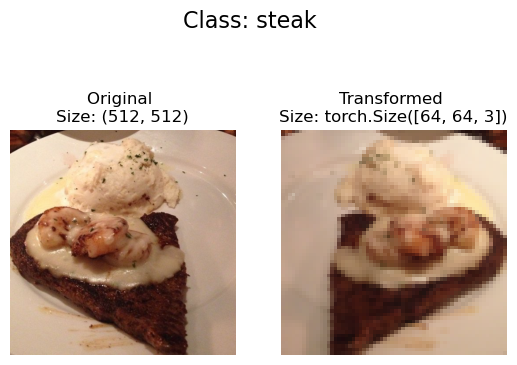

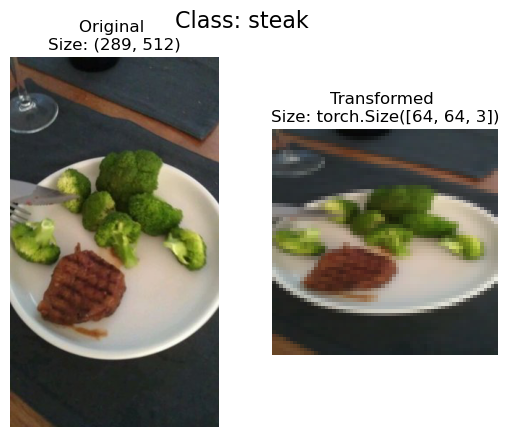

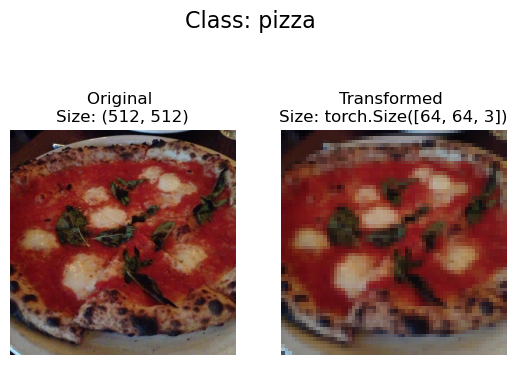

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform) # transforms to perform on data (images)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)
                            

In [14]:
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
dir(train_data)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'extensions',
 'extra_repr',
 'find_classes',
 'imgs',
 'loader',
 'make_dataset',
 'root',
 'samples',
 'target_transform',
 'targets',
 'transform',
 'transforms']

In [16]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
os.cpu_count()

2

In [19]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 1

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE, 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [20]:
dir(train_dataloader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [21]:
img,label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Creating a helper function to get class names

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
# Make function to find classes in target directory
def find_classes(directory: str):
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# Create a function to display random images

In [25]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset, classes, n, seed: int, display_shape: bool = True):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

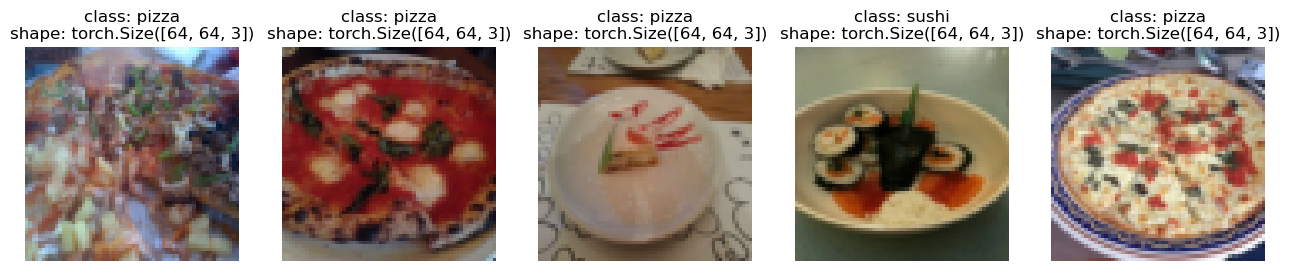

In [26]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

# Other forms of transforms (data augmentation)

In [27]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

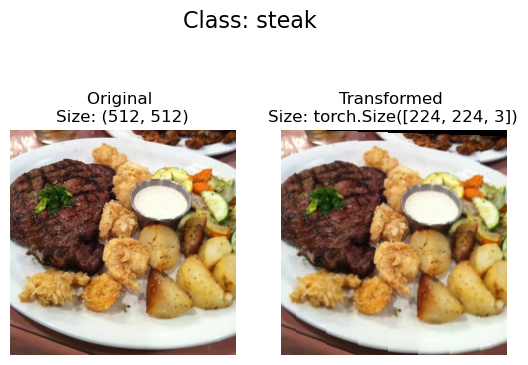

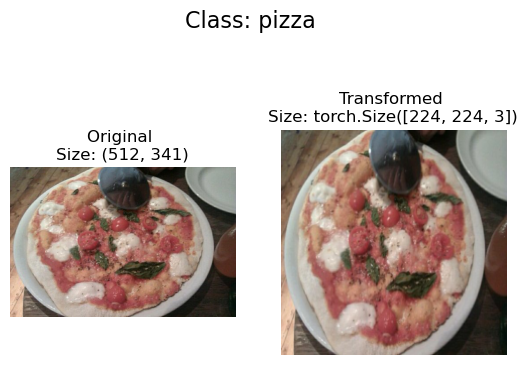

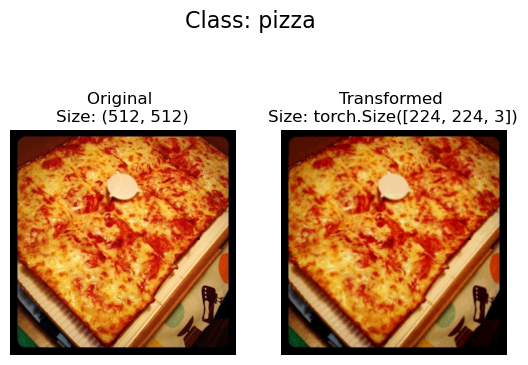

In [28]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# Model 0: TinyVGG without data augmentation

**Creating transforms and loading data for Model 0**

In [29]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [30]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [31]:
# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f56a1f2a2d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f56a1f2a290>)

In [32]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # default stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
 
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        print(f"Output shape of Conv2d_1 is: {x.shape}")
        x = self.block_2(x)
        print(f"Output shape of Conv2d_2 is: {x.shape}")
        x = self.classifier(x)
        print(f"Output shape of classifier is: {x.shape}")
        return x
    

In [33]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes))
model_0.to(device)

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=3, bias=True)
  )
)

# Lets try to find out in_features of classifier method of model 0 . To do that we have to fit a train data into this model 0.

In [34]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [35]:
model_0(img_batch.to(device))

Output shape of Conv2d_1 is: torch.Size([32, 10, 32, 32])
Output shape of Conv2d_2 is: torch.Size([32, 10, 16, 16])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3)

Oh Beautiful. we find the shape torch.Size([32, 10, 16, 16]). From that we pick up 16*16. 

In [36]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # default stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )
 
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(f"Output shape of Conv2d_1 is: {x.shape}")
        x = self.block_2(x)
        #print(f"Output shape of Conv2d_2 is: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape of classifier is: {x.shape}")
        return x
    

In [37]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes))
model_0.to(device)

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [38]:
model_0(img_batch.to(device))

tensor([[0.0624, 0.0591, 0.0388],
        [0.0681, 0.0658, 0.0401],
        [0.0679, 0.0707, 0.0401],
        [0.0738, 0.0627, 0.0442],
        [0.0576, 0.0614, 0.0391],
        [0.0621, 0.0609, 0.0389],
        [0.0646, 0.0620, 0.0400],
        [0.0664, 0.0628, 0.0418],
        [0.0583, 0.0589, 0.0376],
        [0.0622, 0.0610, 0.0344],
        [0.0634, 0.0635, 0.0402],
        [0.0607, 0.0612, 0.0347],
        [0.0601, 0.0637, 0.0375],
        [0.0610, 0.0599, 0.0372],
        [0.0583, 0.0603, 0.0371],
        [0.0671, 0.0635, 0.0343],
        [0.0680, 0.0625, 0.0395],
        [0.0694, 0.0651, 0.0399],
        [0.0613, 0.0612, 0.0382],
        [0.0625, 0.0613, 0.0355],
        [0.0662, 0.0627, 0.0334],
        [0.0630, 0.0637, 0.0382],
        [0.0698, 0.0646, 0.0404],
        [0.0647, 0.0622, 0.0404],
        [0.0644, 0.0620, 0.0405],
        [0.0685, 0.0636, 0.0398],
        [0.0649, 0.0619, 0.0352],
        [0.0643, 0.0651, 0.0388],
        [0.0633, 0.0595, 0.0373],
        [0.060

# Use torchinfo to get an idea of the shapes going through our model

In [39]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

# Setup a loss function and optimizer

In [40]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

# Set up some helper function to get the accuracy and timing bar

In [41]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
# Import accuracy metric
from helper_functions import accuracy_fn

In [42]:
### For timing calculation
# Import tqdm for progress bar
from tqdm.auto import tqdm
from timeit import default_timer as timer  # used to get the code running time
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Create train & test loop functions

In [43]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    # Put model in train mode
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        return test_loss, test_acc

In [44]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                          accuracy_fn=accuracy_fn)
        test_loss, test_acc = test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        #print(train_loss)
        # 5. Update results dictionary
        results["train_loss"].append(train_loss.detach().cpu().numpy())
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss.detach().cpu().numpy())
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

Setup a loss function and optimizer

In [45]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

epochs = 10


# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=epochs)



train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1072 | train_acc: 25.0000 | test_loss: 1.1060 | test_acc: 26.0417
Epoch: 2 | train_loss: 1.0786 | train_acc: 42.5781 | test_loss: 1.1397 | test_acc: 26.0417
Epoch: 3 | train_loss: 1.0808 | train_acc: 42.5781 | test_loss: 1.1698 | test_acc: 26.0417
Epoch: 4 | train_loss: 1.1284 | train_acc: 30.4688 | test_loss: 1.1598 | test_acc: 26.0417
Epoch: 5 | train_loss: 1.0890 | train_acc: 42.5781 | test_loss: 1.1444 | test_acc: 26.0417
Epoch: 6 | train_loss: 1.0954 | train_acc: 30.4688 | test_loss: 1.1469 | test_acc: 26.0417
Epoch: 7 | train_loss: 1.0752 | train_acc: 47.6562 | test_loss: 1.1399 | test_acc: 19.7917
Epoch: 8 | train_loss: 1.0747 | train_acc: 29.2969 | test_loss: 1.1361 | test_acc: 18.7500
Epoch: 9 | train_loss: 1.0511 | train_acc: 46.0938 | test_loss: 1.1005 | test_acc: 36.2689
Epoch: 10 | train_loss: 0.9464 | train_acc: 64.0625 | test_loss: 1.0136 | test_acc: 48.4848
Train time on cuda: 15.468 seconds


# Plot the loss curves of Model 0

From the print outs of our model_0 training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's loss curves.

Loss curves show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our model_0_results dictionary.

In [46]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [47]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

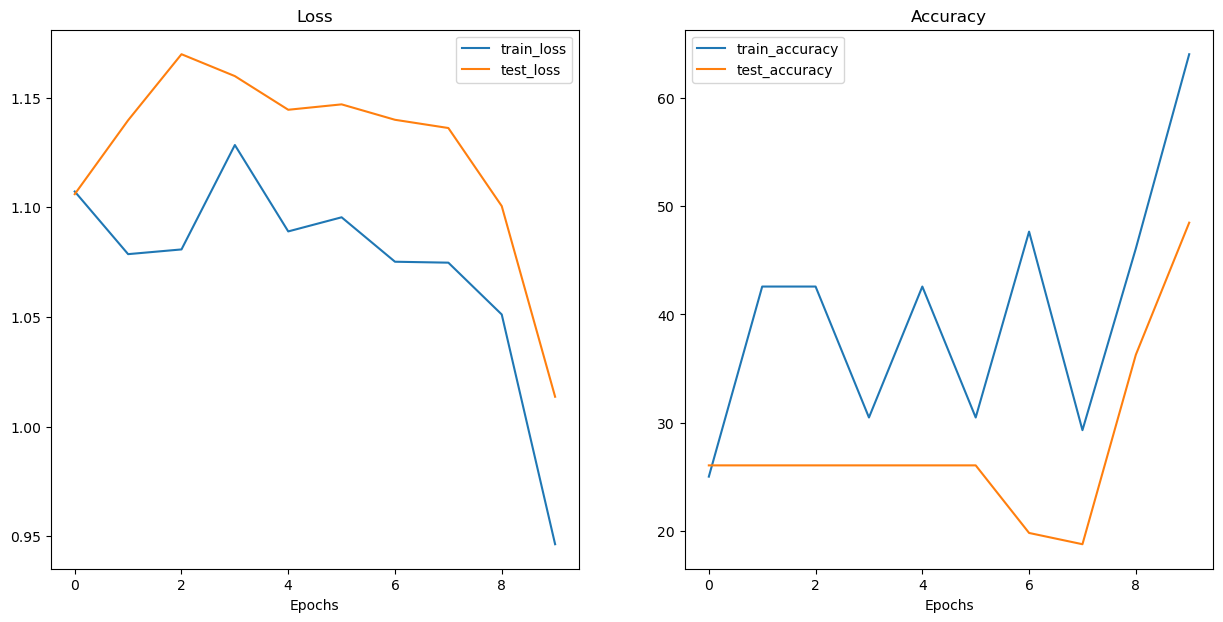

In [48]:
plot_loss_curves(model_0_results)

# Model 1: TinyVGG with Data Augmentation

## Create transform with data augmentation

In [49]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [50]:
train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [51]:
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)
# Create DataLoader's
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f56a5c76890>,
 <torch.utils.data.dataloader.DataLoader at 0x7f56a5c768d0>)

In [52]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data_augmented.classes))
model_1.to(device)

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [53]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.01)

In [54]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

epochs = 10


# Train model_0 
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=epochs)



train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0978 | train_acc: 26.9531 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 2 | train_loss: 1.0976 | train_acc: 38.2812 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 3 | train_loss: 1.0971 | train_acc: 38.6719 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 4 | train_loss: 1.0975 | train_acc: 28.1250 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 5 | train_loss: 1.0974 | train_acc: 37.8906 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 6 | train_loss: 1.0973 | train_acc: 38.6719 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 7 | train_loss: 1.0977 | train_acc: 26.9531 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 8 | train_loss: 1.0975 | train_acc: 24.6094 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 9 | train_loss: 1.1011 | train_acc: 23.4375 | test_loss: 1.1037 | test_acc: 20.8333
Epoch: 10 | train_loss: 1.0978 | train_acc: 26.5625 | test_loss: 1.1037 | test_acc: 20.8333
Train time on cuda: 14.966 seconds


In [55]:
model_1_results

{'train_loss': [array(1.0977865, dtype=float32),
  array(1.0975841, dtype=float32),
  array(1.0970745, dtype=float32),
  array(1.0974615, dtype=float32),
  array(1.0974224, dtype=float32),
  array(1.0972579, dtype=float32),
  array(1.0976721, dtype=float32),
  array(1.0974634, dtype=float32),
  array(1.1010988, dtype=float32),
  array(1.0977664, dtype=float32)],
 'train_acc': [26.953125,
  38.28125,
  38.671875,
  28.125,
  37.890625,
  38.671875,
  26.953125,
  24.609375,
  23.4375,
  26.5625],
 'test_loss': [array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32),
  array(1.1037269, dtype=float32)],
 'test_acc': [20.833333333333332,
  20.833333333333332,
  20.833333333333332,
  20.833333333333332,
  20.833333333333332,
  20.83333333

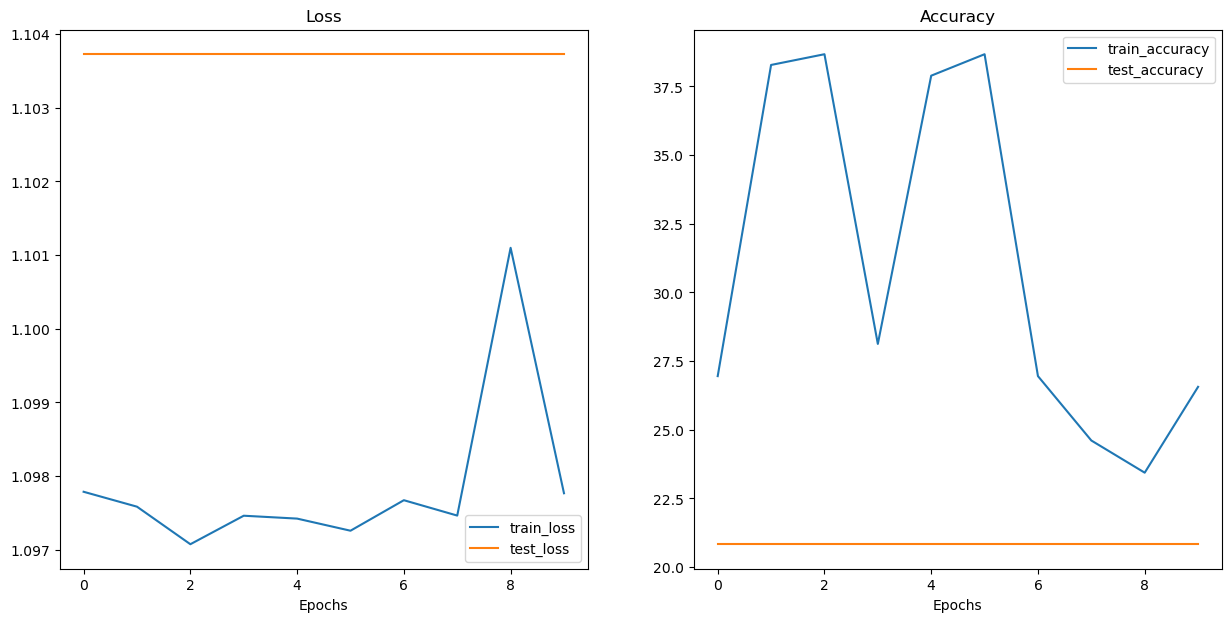

In [56]:
#Plot the loss curves of Model 1
plot_loss_curves(model_1_results)

# Compare model results

In [57]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.1071858,25.000000,1.1059768,26.041667
1,1.0786312,42.578125,1.1396558,26.041667
2,1.0807799,42.578125,1.169758,26.041667
3,1.128369,30.468750,1.1597841,26.041667
4,1.0889896,42.578125,1.1444407,26.041667
5,1.0954278,30.468750,1.146903,26.041667
6,1.0751723,47.656250,1.1398737,19.791667
7,1.0747465,29.296875,1.1361187,18.750000
8,1.0511292,46.093750,1.1005406,36.268939
9,0.94640845,64.062500,1.0136309,48.484848


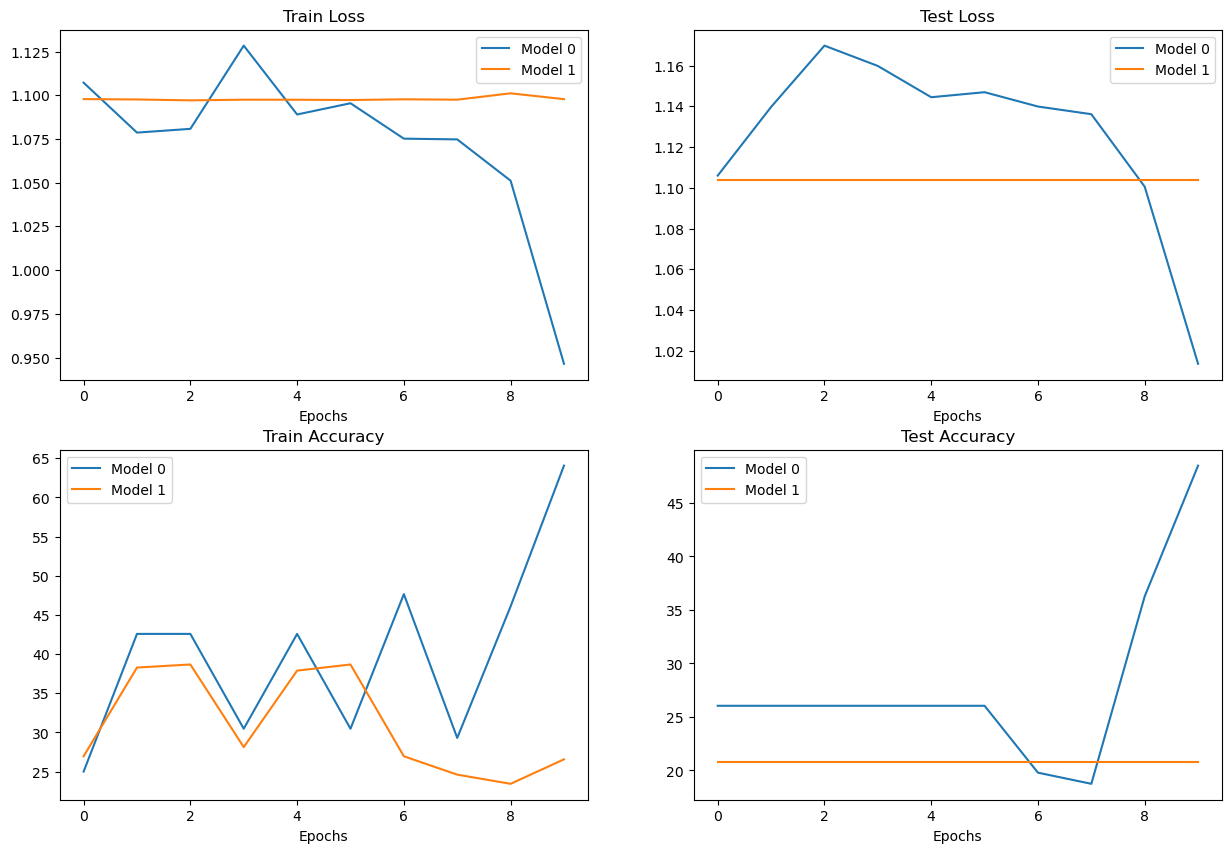

In [58]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Make a prediction on a custom image

In [74]:
# Download custom image
import requests
from PIL import Image
from torchvision import transforms
# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


In [76]:
# Convert the image into tensor
img = Image.open(custom_image_path)
convert_tensor = transforms.ToTensor()
custom_image = convert_tensor(img)

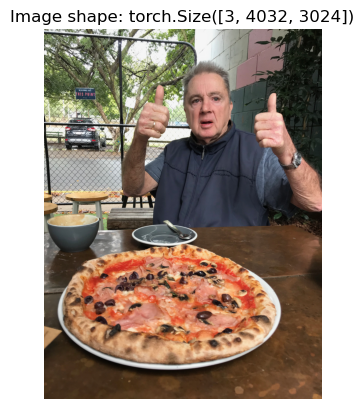

In [78]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

## But our model is trained for [3, 64, 64] shape

In [77]:
print(f"Custom image dtype: {custom_image.dtype}")

Custom image dtype: torch.float32


# Predicting on custom images with a trained PyTorch model

In [79]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [82]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

It looks like we're getting a shape error.

Why might this be?

We converted our custom image to be the same size as the images our model was trained on...

Oh wait...

There's one dimension we forgot about.

The batch size.

Our model expects image tensors with a batch size dimension at the start (NCHW where N is the batch size).

Except our custom image is currently only CHW.

We can add a batch size dimension using torch.unsqueeze(dim=0) to add an extra dimension our image and finally make a prediction.

Essentially we'll be telling our model to predict on a single image (an image with a batch_size of 1).

In [83]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [84]:
custom_image_pred

tensor([[0.0656, 0.0681, 0.0397]], device='cuda:0')

**Note:** What we've just gone through are three of the classical and most common deep learning and PyTorch issues:

* **Wrong datatypes** - our model expects torch.float32 where our original custom image was uint8.
* **Wrong device** - our model was on the target device (in our case, the GPU) whereas our target data hadn't been moved to the target device yet.
* **Wrong shapes** - our model expected an input image of shape [N, C, H, W] or [batch_size, color_channels, height, width] whereas our custom image tensor was of shape [color_channels, height, width].

In [85]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[0.0656, 0.0681, 0.0397]], device='cuda:0')
Prediction probabilities: tensor([[0.3359, 0.3368, 0.3273]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


In [90]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label] # put pred label to CPU, otherwise will error
custom_image_pred_class

'steak'

It predict's the wrong one. Because our model is very poor.

# Make it all together

In [95]:
def pred_and_plot_image(model, image_path, class_names, transform, device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # Convert the image into tensor
    img = Image.open(image_path)
    convert_tensor = transforms.ToTensor()
    target_image = convert_tensor(img) 
    
    # Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max():.3f}"
    plt.title(title)
    plt.axis(False);

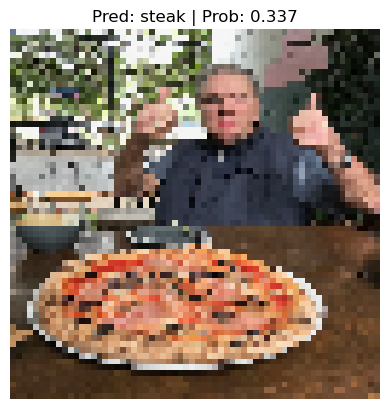

In [96]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)